In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from glob import glob
from PIL import Image
from torchvision import transforms, utils
from IPython.display import display
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH = 'drive/MyDrive/Advanced RL and DL hw3/'

In [19]:
BATCH_SIZE = 8
LR = 0.0001
BETA = 0.5
N_STEPS = 250

In [20]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, folder=PATH + 'facades/train'):
        self.folder = folder
        self.files = glob(self.folder + '/*.jpg');
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
        ])
        
    def __getitem__(self, idx):
        imgs = Image.open(self.files[idx]).convert("RGB")
        img_from, img_to = imgs.crop((256, 0, 512, 256)), imgs.crop((0, 0, 256, 256))
        return self.transforms(img_from), self.transforms(img_to)    
        
    def __len__(self):
        return len(self.files)


train_dataset = Dataset(folder=PATH + 'facades/train')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = Dataset(folder=PATH + 'facades/test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
class UnetSkipConnectionBlock(nn.Module):
    """Unet submodule with skip connection."""

    def __init__(self, outer_nc, inner_nc, input_nc=None, submodule=None, outermost=False, 
                 innermost=False, use_bias=False, use_dropout=False):
        """Constructor of a Unet submodule with skip connections.
        Parameters:
            outer_nc, int - the number of filters in the outer conv layer
            inner_nc, int - the number of filters in the inner conv layer
            input_nc, int - the number of channels in input images
            submodule, UnetSkipConnectionBlock - previously defined submodules
            outermost, bool - if this module is the outermost module
            innermost, bool - if this module is the innermost module
            use_bias, bool - use bias or not
            use_dropout, bool - use dropout or not
        """
        super().__init__()
        self.outermost = outermost
            
        if input_nc is None:
            input_nc = outer_nc
            
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1)
            model = [downconv] + [submodule] + [uprelu, upconv, nn.Tanh()]
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            model = [downrelu, downconv] + [uprelu, upconv, upnorm]
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            if use_dropout:
                model = [downrelu, downconv, downnorm] + [submodule] + [uprelu, upconv, upnorm] + [nn.Dropout(0.5)]
            else:
                model = [downrelu, downconv, downnorm] + [submodule] + [uprelu, upconv, upnorm]
                

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)


class UnetGenerator(nn.Module):
    """Unet-based generator."""

    def __init__(self, input_nc, output_nc, n_downs, n_filt=64, use_bias=False, use_dropout=False):
        """Constructor of a Unet generator.
        Parameters:
            input_nc, int - the number of channels in input images
            output_nc, int - the number of channels in output images
            n_downs, int - the number of downsamplings
            n_filt, int - the number of filters
            use_bias, bool - use bias or not
            use_dropout, bool - use dropout or not
        """
        super().__init__()
        # add the innermost layer
        unet_block = UnetSkipConnectionBlock(n_filt * 8, n_filt * 8, input_nc=None, 
                                             submodule=None, use_bias=use_bias, innermost=True)
        # add intermediate layers recursively
        for i in range(n_downs - 5):
            unet_block = UnetSkipConnectionBlock(n_filt * 8, n_filt * 8, input_nc=None, 
                                                 submodule=unet_block, use_bias=use_bias, 
                                                 use_dropout=use_dropout)
            
        # reduce the number of filters
        unet_block = UnetSkipConnectionBlock(n_filt * 4, n_filt * 8, input_nc=None, 
                                             submodule=unet_block, use_bias=use_bias)
        unet_block = UnetSkipConnectionBlock(n_filt * 2, n_filt * 4, input_nc=None, 
                                             submodule=unet_block, use_bias=use_bias)
        unet_block = UnetSkipConnectionBlock(n_filt, n_filt * 2, input_nc=None, 
                                             submodule=unet_block, use_bias=use_bias)
        
        # add the outermost layer
        self.model = UnetSkipConnectionBlock(output_nc, n_filt, input_nc=input_nc, 
                                             submodule=unet_block, outermost=True, use_bias=use_bias)

    def forward(self, x):
        """Forward pass."""
        return self.model(x)


In [22]:
class Discriminator(nn.Module):
    """Discriminator class."""

    def __init__(self, input_dim, n_filt=64, use_bias=False):
        """Constructor of discriminator.
        Parameters:
            input_dim, int - the number of channels in input images
            n_filt, int - the number of filters
            use_bias, bool - use bias or not
        """
        super().__init__()

        self.conv1 = nn.Conv2d(input_dim, n_filt, kernel_size=1, stride=1, padding=0)
        self.leaky_relu = nn.LeakyReLU(0.2, True)
        self.conv2 = nn.Conv2d(n_filt, n_filt * 2, kernel_size=1, stride=1, padding=0, bias=use_bias)
        self.batch_norm = nn.BatchNorm2d(n_filt * 2)
        self.conv3 = nn.Conv2d(n_filt * 2, n_filt * 4, kernel_size=1, stride=1, padding=0, bias=use_bias)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.adapt_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(n_filt * 4, 2)

    def forward(self, x):
        """Forward pass."""
        x1 = self.leaky_relu(self.conv1(x))
        x2 = self.leaky_relu(self.batch_norm(self.conv2(x1)))
        x3 = self.adapt_avg_pool(self.max_pool(self.conv3(x2)))
        out = self.linear(x3.squeeze(-1).squeeze(-1))
        
        return out

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [24]:
gen = UnetGenerator(input_nc=3, output_nc=3, num_downs=8, ngf=64, 
                    use_bias=False, use_dropout=False).to(device)
discr = Discriminator(input_dim=3 + 3, num_filters=64, use_bias=False).to(device)

In [25]:
gen_opt = torch.optim.Adam(gen.parameters(), lr=LR, betas=(BETA, 0.999))
discr_opt = torch.optim.Adam(discr.parameters(), lr=LR, betas=(BETA, 0.999))

Epoch: 50
Исходное изображение - 1ый ряд, целевое изображение - 2ой ряд, полученное изображение - 3ий ряд


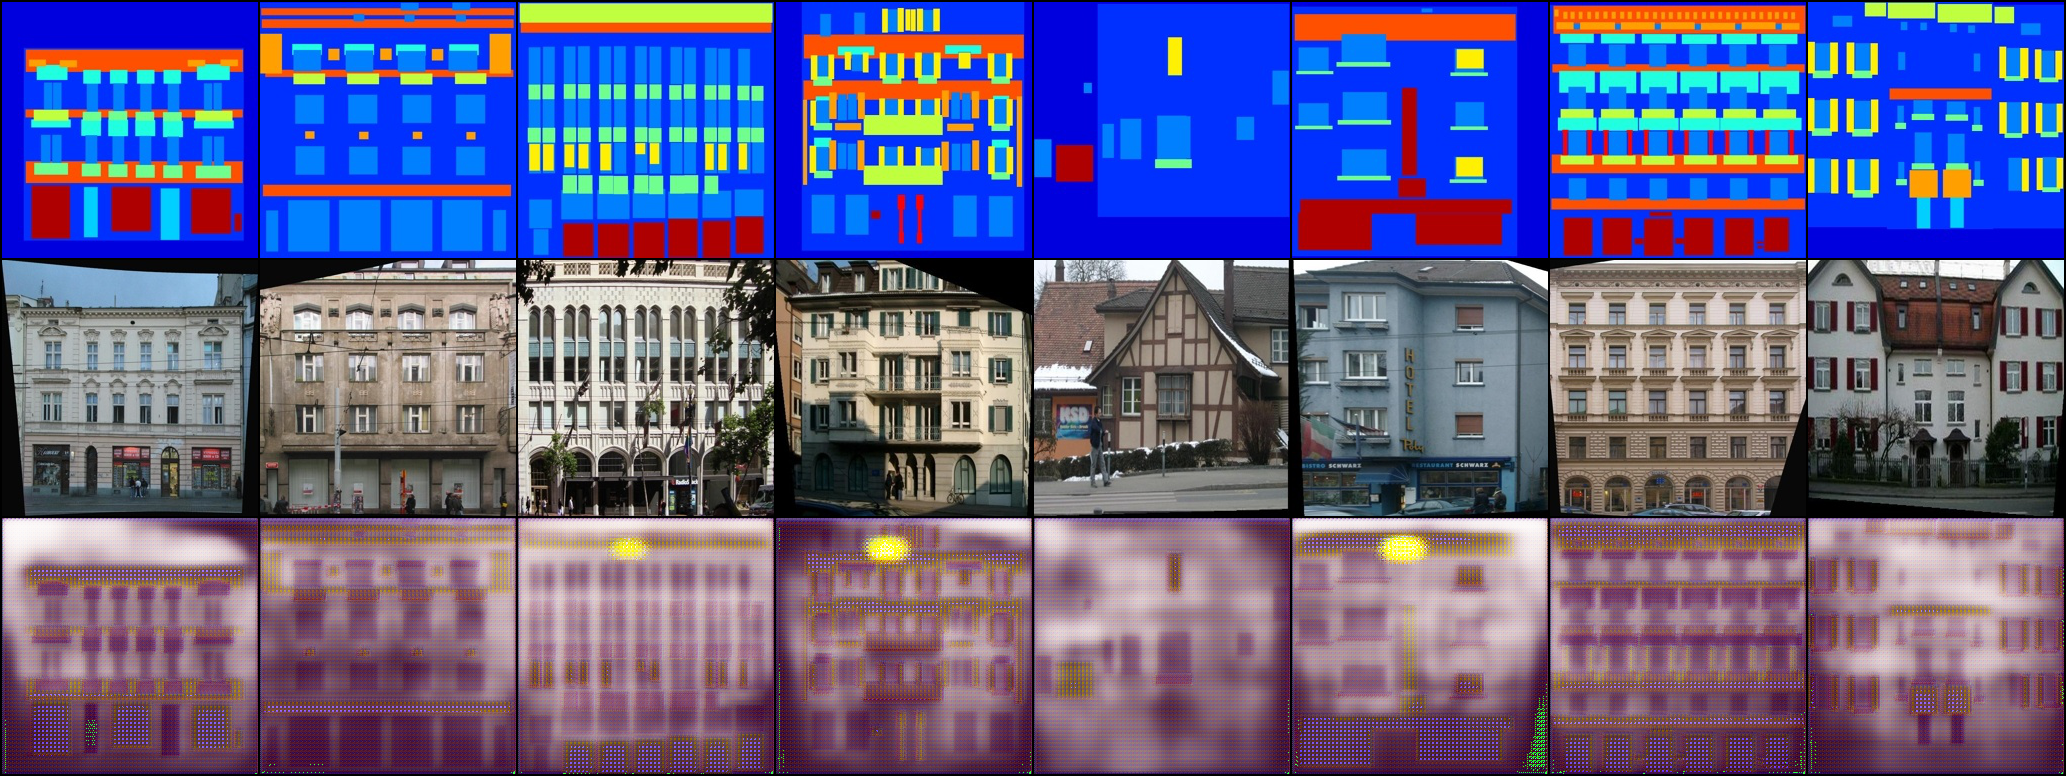

Epoch: 100
Исходное изображение - 1ый ряд, целевое изображение - 2ой ряд, полученное изображение - 3ий ряд


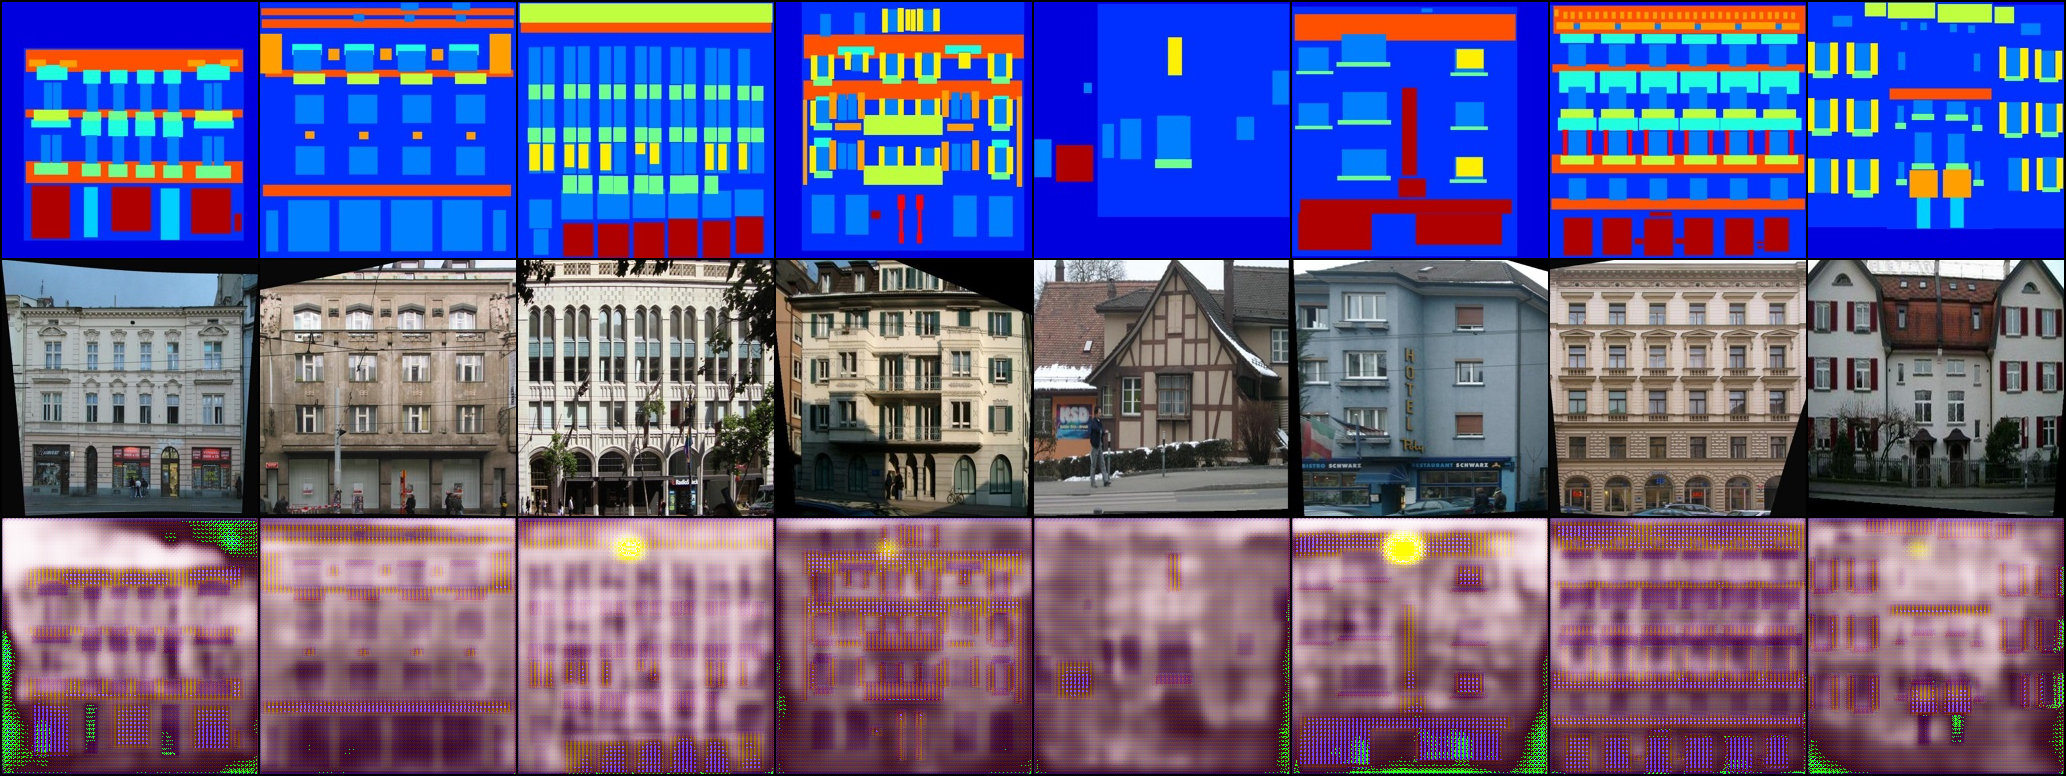

 56%|█████▌    | 28/50 [00:34<00:27,  1.23s/it, gen_loss=10, discr_loss=0.000129]

In [ ]:
gen_hist, discr_hist = [], []
test_img_source, test_img_real = next(iter(test_dataloader))

for epoch in range(1, N_STEPS + 1):
    
    bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False, position=0)
    for i, batch in bar:
        # Get images
        img_source, img_real = batch
        img_source = img_source.to(device)
        img_real = img_real.to(device)

        # Turn right mode
        gen.eval()
        discr.train()

        # Learn discriminator
        img_fake = gen(img_source)
        logit_real = discr(torch.cat((img_source, img_real), 1))
        logit_fake = discr(torch.cat((img_source, img_fake), 1))
        ones = torch.ones(logit_real.shape[0]).long().to(device)
        zeros = torch.zeros(logit_fake.shape[0]).long().to(device)
        real_loss = F.cross_entropy(logit_real, ones)
        fake_loss = F.cross_entropy(logit_fake, zeros)
        discr_loss = (fake_loss + real_loss) * 0.5
        
        # Discriminator optimizer step
        discr_opt.zero_grad()
        discr_loss.backward()
        discr_opt.step()
        discr_hist.append(discr_loss.item())
        
        # Turn right mode
        gen.train()
        discr.eval()
        
        # Learn generator
        img_fake = gen(img_source)
        logit_fake = discr(torch.cat((img_source, img_fake), 1))
        ones = torch.ones(logit_fake.shape[0]).long().to(device)
        gen_entropy_loss = F.cross_entropy(logit_fake, ones)
        gen_loss = gen_entropy_loss + 100 * F.l1_loss(img_fake, img_real)
        
        # Generator optimizer step
        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()
        gen_hist.append(gen_loss.item())

        bar.set_postfix({'gen_loss': gen_hist[-1], 'discr_loss': discr_hist[-1]})

    if epoch % 50 == 0:
        print(f'Epoch: {epoch}')
        print('Исходное изображение - 1ый ряд, целевое изображение - 2ой ряд, полученное изображение - 3ий ряд')
        gen.train()
        test_img_fake = gen(test_img_source.to(device)).cpu().detach()
        img = torch.cat([test_img_source, test_img_real, test_img_fake], dim=0)
        display(transforms.ToPILImage()(utils.make_grid(img)))